Making of the neural network, training of the neural network, and testing on various model happens here.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu

U-net model

In [2]:
from models_class.unet_das_2 import UNet

Load the alphabets.

In [3]:
import pickle

alpha = {}
dirty_alpha = {}
with open('../Input_Representation/data/other/alphabet.pkl', 'rb') as f:
    alpha = pickle.load(f)
with open('../Input_Representation/data/other/dirty_alphabet.pkl', 'rb') as f:
    dirty_alpha = pickle.load(f)


Making the dataset and making the Dataloader.

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split
from random_transformation import RandomTransformation

class MyDataset(Dataset):
    '''
    Contains the dataset.
    '''
    def __init__(self, alpha, dirty_alpha, transform=None):
        '''
        Initialize the dataset.
        '''
        self.data = []
        self.labels = []
        self.n = 5
        for key, value in alpha.items():
            if key in dirty_alpha:
                for i, stroke in enumerate(dirty_alpha[key]):
                    self.labels.append(torch.Tensor(value[0]))
                    self.data.append(torch.Tensor(stroke))
            else:
                continue

    def __getitem__(self, index):
        x = self.data[index // self.n]
        y = self.labels[index // self.n]
        return x, y

    def __len__(self):
        return len(self.data)*self.n
    
class MyDataset2(Dataset):
    '''
    Contains the dataset.
    '''
    def __init__(self, alpha, dirty_alpha, transform=None):
        '''
        Initialize the dataset.
        '''
        self.data = []
        self.labels = []
        self.n = 1
        for key, value in alpha.items():
            if key in dirty_alpha:
                for i, stroke in enumerate(dirty_alpha[key]):
                    self.labels.append(value[0])
                    self.data.append(stroke)
            else:
                continue

    def applyTransform(self, data):
        '''
        Apply a random transformation to the data.
        '''
        rand = RandomTransformation()
        return rand(data)
    
    def getData(self, index):
        data = self.data[index // self.n]
        transformed_data = self.applyTransform(data)
        return torch.Tensor(transformed_data.copy())
    
    def getLabels(self, index):
        return torch.Tensor(self.labels[index // self.n])

    def __getitem__(self, index):
        return self.getData(index), self.getLabels(index)

    def __len__(self):
        return len(self.data)*self.n


Compose the random linear transformation on the Tensor.

In [5]:
# from torchvision.transforms import (
    
# )

Make the Dataloader.

In [6]:
# dataset = MyDataset(alpha, dirty_alpha)
# dataloader = DataLoader(dataset=dataset, batch_size=648, shuffle=True, num_workers=1)
dataset = MyDataset2(alpha, dirty_alpha)
dataloader = DataLoader(dataset=dataset, batch_size=648, shuffle=True, num_workers=1)
# dataset_train, dataset_valid = random_split(dataset, [len(dataset)-72, 72])
# dataloader_train = DataLoader(dataset=dataset_train, batch_size=576, shuffle=False, num_workers=1)
# dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=72, shuffle=False, num_workers=1)

# print(f"Total amount of Tensors in Training Dataset: {dataloader_train.dataset.__len__()}")
# print(f"Total amount of Tensors in Validation Dataset: {dataloader_valid.dataset.__len__()}")

Plot the input.

In [7]:
# dataiter = iter(dataloader)
# # dataiter2 = iter(dataloader_valid)
# data = next(dataiter)
# data2 = next(dataiter)
# features, labels = data
# features2, labels2 = data2

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, label="dirty")
# ax.plot(features2[0][0], features2[0][1]*-1, label="transformed")
# ax.set_aspect('equal', adjustable='box')
# ax.legend()

# plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

num_epochs = 10
learning_rate = 0.0001

model = UNet(3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(dataloader)
losses = []
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        # outputs = torch.Tensor([interpolate(stroke, 252) for stroke in model(features).detach().numpy()])
        outputs = model(features)
        loss = criterion(outputs.requires_grad_(), labels)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), './models/model_das_2.ckpt')


cuda
Epoch [1/20], Step [1/5], Loss: 292.2298
Epoch [1/20], Step [2/5], Loss: 287.3981
Epoch [1/20], Step [3/5], Loss: 309.2776
Epoch [1/20], Step [4/5], Loss: 302.0682
Epoch [1/20], Step [5/5], Loss: 299.6113
Epoch [2/20], Step [1/5], Loss: 301.1864
Epoch [2/20], Step [2/5], Loss: 296.9058
Epoch [2/20], Step [3/5], Loss: 296.5472
Epoch [2/20], Step [4/5], Loss: 285.4828
Epoch [2/20], Step [5/5], Loss: 298.8889
Epoch [3/20], Step [1/5], Loss: 293.7852
Epoch [3/20], Step [2/5], Loss: 293.6489
Epoch [3/20], Step [3/5], Loss: 296.3771
Epoch [3/20], Step [4/5], Loss: 294.1680
Epoch [3/20], Step [5/5], Loss: 288.0128
Epoch [4/20], Step [1/5], Loss: 277.9518
Epoch [4/20], Step [2/5], Loss: 295.8112
Epoch [4/20], Step [3/5], Loss: 288.9247
Epoch [4/20], Step [4/5], Loss: 296.4513
Epoch [4/20], Step [5/5], Loss: 290.0526
Epoch [5/20], Step [1/5], Loss: 279.8126
Epoch [5/20], Step [2/5], Loss: 286.8163
Epoch [5/20], Step [3/5], Loss: 294.4590
Epoch [5/20], Step [4/5], Loss: 279.9942
Epoch [5/20

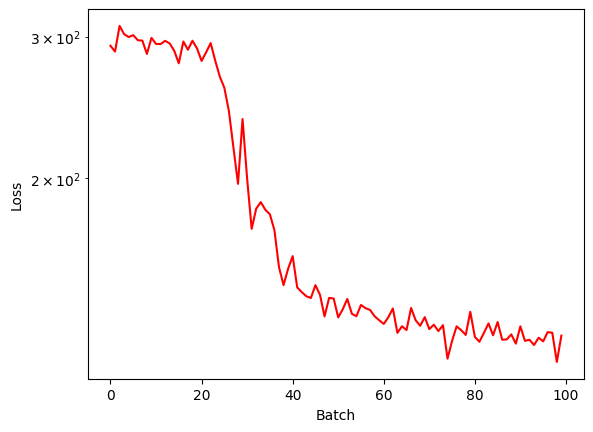

In [9]:
# torch.save(model.state_dict(), './models/model_plusp.ckpt')

with open("./data/losses/loss_das_2.pkl", "wb") as f:
            pickle.dump(losses, f)

# fig = plt.figure()
plt.plot(losses, color='red')
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.savefig('figs/loss_das_2.png')
plt.show()

In [10]:
# n = 10
# plt.figure(figsize=(10, 20))
# plt.subplots_adjust(hspace=1)
# dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=1)
# dataiter = iter(dataloader)
# model = model.to("cpu")

# for i, data in enumerate(dataiter):
#     if i == n:
#         break
#     features, labels = data
#     outputs = model(features)
#     outputs = outputs.to("cpu")

#     ax1 = plt.subplot(10, 3, 3*(i)+1)
#     ax2 = plt.subplot(10, 3, 3*(i)+2)
#     ax3 = plt.subplot(10, 3, 3*(i)+3)
    
#     ax1.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, color="red", label="input")
#     ax2.plot(outputs[0].detach().numpy()[0], outputs[0].detach().numpy()[1]*-1, color="blue", label="output")
#     ax3.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, color="green", label="label")

#     ax1.set_aspect('equal', adjustable='box')
#     ax2.set_aspect('equal', adjustable='box')
#     ax3.set_aspect('equal', adjustable='box')

# plt.show()

